In [2]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage.interpolation import zoom
from sklearn.model_selection import train_test_split

from utils import load_nifti

In [3]:
output_shape = (96, 114, 96)
z_factor = 0.5
test_percentage = 0.2

# Prepare datasets

## 2 Year complete dataset

In [4]:
complete_annual_2yr_dir = "/analysis/share/ADNI/ADNI_tables/customized/ClassDxByImgClean_CompleteAnnual2YearVisitList_1_5T.csv"

In [5]:
df_2yr = pd.read_csv(complete_annual_2yr_dir)

In [6]:
df_2yr.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,...,Series.ID,DX_bl,DX_m12,DX_m24,DXdevelop,converter,label_three_fold,label_CN_AD,label_CN_MCI,label_MCI_AD
0,3,011_S_0003,bl,Dementia,2005-09-12,32237,9/1/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,...,9127,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
1,3,011_S_0003,m12,Dementia,2006-09-12,35576,9/12/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9672,...,19096,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
2,3,011_S_0003,m24,Dementia,2007-09-12,88252,9/12/07,MPR; GradWarp; B1 Correction; N3; Scaled,Month 24,23.9344,...,39296,Dementia,Dementia,Dementia,Dementia-Dementia-Dementia,0,2,1.0,NaN,1.0
3,5,011_S_0005,bl,CN,2005-09-07,32246,9/2/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,...,9136,CN,CN,CN,CN-CN-CN,0,0,0.0,0.0,NaN
4,5,011_S_0005,m12,CN,2006-09-05,31906,9/5/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9016,...,19041,CN,CN,CN,CN-CN-CN,0,0,0.0,0.0,NaN


In [7]:
print("Length with all subjects {}".format(len(df_2yr)))

Length with all subjects 1590


In [8]:
# remove MCI scans
df_2yr = df_2yr[~np.isnan(df_2yr["label_CN_AD"])]
print("Length without MCI {}".format(len(df_2yr)))

Length without MCI 969


In [9]:
print(len(df_2yr[df_2yr.DX == "CN"]))
print(len(df_2yr[df_2yr.DX == "Dementia"]))
print(len(df_2yr[df_2yr.DX == "MCI"]))

494
475
0


## Screening dataset

In [10]:
screening_unqiue_doc = "/analysis/share/ADNI/ADNI_tables/customized/DxByImgClean_ADNI_Screening_Unique_15T.csv"

In [11]:
df_screening = pd.read_csv(screening_unqiue_doc)

In [12]:
df_screening.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,Screen.Diagnosis,Study.ID,Series.ID,label_three_fold,label_CN_AD,label_CN_MCI,label_MCI_AD
0,2,011_S_0002,bl,CN,2005-09-08,35475,8/26/05,MPR; GradWarp; B1 Correction; N3; Scaled,Screening,0,NL,1945,9107,0,0.0,0.0,NaN
1,4,022_S_0004,bl,MCI,2005-11-08,64631,9/22/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0,MCI,1990,9234,1,NaN,1.0,0.0
2,6,100_S_0006,bl,MCI,2005-11-29,33025,11/15/05,MPR; ; N3; Scaled,Screening,0,MCI,2674,10145,1,NaN,1.0,0.0
3,7,022_S_0007,bl,Dementia,2005-10-06,59366,9/13/05,MPR; GradWarp; B1 Correction; N3; Scaled,Screening,0,AD,1972,9024,2,1.0,NaN,1.0
4,15,100_S_0015,bl,CN,2005-10-18,33066,9/26/05,MPR-R; ; N3; Scaled,Screening,0,NL,1993,9246,0,0.0,0.0,NaN


In [13]:
# check that there is no overlap between 2 year and screening
assert(len(df_2yr[df_2yr["PTID"].isin(list(df_screening["PTID"]))]) == 0)

In [14]:
# remove duplicate scans from the same person in the unique dataset
df_screening = df_screening.drop_duplicates(subset="PTID", keep="first")

In [15]:
# remove MCI scans
df_screening = df_screening[~np.isnan(df_screening["label_CN_AD"])]
print("Length without MCI {}".format(len(df_screening)))

Length without MCI 143


In [16]:
print(len(df_screening[df_screening.DX == "CN"]))
print(len(df_screening[df_screening.DX == "Dementia"]))
print(len(df_screening[df_screening.DX == "MCI"]))

54
89
0


## Split holdout dataset

In [17]:
subjects_2yr = df_2yr["PTID"].unique()
subjects_screening = df_screening["PTID"].unique()
print(len(subjects_2yr))
print(len(subjects_screening))

344
143


In [19]:
train_subjects_2yr, test_subjects_2yr = train_test_split(subjects_2yr, test_size=test_percentage)
train_subjects_screening, test_subjects_screening = train_test_split(subjects_screening, test_size=test_percentage)

In [20]:
train_df_2yr = df_2yr[df_2yr["PTID"].isin(train_subjects_2yr)]
test_df_2yr = df_2yr[df_2yr["PTID"].isin(test_subjects_2yr)]
train_df_screening = df_screening[df_screening["PTID"].isin(train_subjects_screening)]
test_df_screening = df_screening[df_screening["PTID"].isin(test_subjects_screening)]

In [21]:
print(len(train_df_2yr))
print(len(test_df_2yr))
print(len(train_df_screening))
print(len(test_df_screening))

789
180
114
29


## Make dataset

In [22]:
mask = load_nifti("/analysis/share/Ritter/Masks/ICBM_152/mni_icbm152_nlin_asym_09c/binary_brain_mask.nii.gz")

In [23]:
root_dir = "/analysis/share/ADNI/"

In [24]:
# load images in matrix
def create_dataset(dataset, z_factor, output_shape, mask=None):
    dataset.reset_index(inplace=True)
    dataset = dataset.drop("index", axis="columns")
    data_matrix = np.empty(shape=((len(dataset),) + output_shape))
    file_paths = []
    labels = np.empty(shape=((len(dataset),)))
    for idx, row in dataset.iterrows():
        ptid = row["PTID"]
        visit = row["Visit"].replace(" ", "") # remove blanks visit type
        image_id = row["Image.ID"]
        path = os.path.join(file_dir, ptid, visit,  "*"+str(image_id)+"*.ni*")
        print(path)
        # select first scan if multiple available
        scan = glob.glob(path)[0]
        file_paths.append(scan)
        struct_arr = load_nifti(scan, z_factor=z_factor, mask=mask)
        data_matrix[idx] = struct_arr
        labels[idx] = (row["DX"] == "Dementia") *1
    return data_matrix, labels, file_paths

### 2 Year complete dataset

In [25]:
file_dir = os.path.join(root_dir, "ADNI_2Yr_15T_quick_preprocessed")

In [118]:
train_dataset_2yr, train_labels_2yr, train_file_paths_2yr = create_dataset(train_df_2yr, z_factor=z_factor, output_shape=output_shape, mask=mask)
test_dataset_2yr, test_labels_2yr, test_file_paths_2yr = create_dataset(test_df_2yr, z_factor=z_factor, output_shape=output_shape, mask=mask)

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Screening/*32237*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month12/*35576*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month24/*88252*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Screening/*59375*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Month12/*59391*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Month24/*87012*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0016/Screening/*32306*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0016/Month12/*31933*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0016/Month24/*200390*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0023/Screening/*32409*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0023/Month12/*65902*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0023/Mon

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0106/Month12/*66682*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0106/Month12/*119309*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0106/Month24/*94804*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0108/Month24/*97220*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Screening/*63454*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Screening/*130231*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month12/*83135*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month12/*130233*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/068_S_0109/Month24/*102511*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/127_S_0112/Month24/*91972*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_0118/Screening/*34114*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_0118/Sc

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/098_S_0269/Month12/*67232*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/098_S_0269/Month24/*102797*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0283/Screening/*66428*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0283/Month12/*67027*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/137_S_0283/Month24/*103508*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0286/Screening/*37007*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0286/Screening/*118779*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0286/Month12/*67104*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0286/Month12/*118788*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/018_S_0286/Month24/*108440*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/130_S_0289/Month24/*123389*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/007_S_0293/

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/032_S_0400/Month24/*108024*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_0403/Screening/*34181*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_0403/Month12/*70692*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_0403/Month24/*105897*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0413/Screening/*45117*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0413/Screening/*118673*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0413/Month12/*60008*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0413/Month24/*120917*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/010_S_0419/Screening/*63320*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/010_S_0419/Screening/*118701*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/010_S_0419/Month12/*72162*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/010_S_04

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0559/Screening/*118676*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0559/Month12/*74568*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0559/Month24/*120949*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0565/Screening/*39919*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0565/Screening/*119234*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0565/Month12/*75476*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/073_S_0565/Month24/*123926*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/033_S_0567/Month12/*67448*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/033_S_0567/Month24/*109934*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/031_S_0568/Month12/*71512*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/031_S_0568/Month24/*111217*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0576/

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_0753/Screening/*33461*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_0753/Month12/*78869*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/021_S_0753/Month24/*134624*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0759/Screening/*36969*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0759/Month12/*82336*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0759/Month24/*123119*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/141_S_0767/Screening/*47306*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/141_S_0767/Month12/*124940*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/141_S_0767/Month24/*124344*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0768/Screening/*50506*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0768/Month12/*80276*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/062_S_0768/

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0938/Month12/*81312*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0938/Month24/*125155*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/057_S_0941/Month12/*82342*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/057_S_0941/Month24/*125038*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_0951/Screening/*64170*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_0951/Screening/*119138*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_0951/Month12/*85524*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_0951/Month24/*129340*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/052_S_0952/Month24/*129571*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0963/Screening/*89417*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0963/Screening/*118903*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_096

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_1188/Month12/*91882*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/094_S_1188/Month24/*135281*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1194/Screening/*63847*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1194/Month12/*103731*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1194/Month24/*137271*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1197/Screening/*66462*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1197/Month12/*108336*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1197/Month24/*142493*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1202/Screening/*63874*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/941_S_1202/Month12/*105437*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_1213/Month12/*94453*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/027_S_1213/

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0010/Month24/*94377*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0021/Screening/*32332*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0021/Month12/*31970*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0021/Month24/*200399*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0050/Month12/*66664*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0050/Month12/*119272*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/123_S_0050/Month24/*88072*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0058/Screening/*108504*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0058/Screening/*118832*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0058/Month12/*134207*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/023_S_0058/Month24/*89591*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0066/S

/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/005_S_0572/Month24/*122622*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/013_S_0575/Screening/*51160*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/013_S_0575/Month12/*78805*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/013_S_0575/Month24/*122796*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0577/Screening/*36914*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0577/Month12/*72195*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/036_S_0577/Month24/*108445*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0619/Screening/*48617*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0619/Screening/*118678*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0619/Month12/*67871*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/002_S_0619/Month24/*120964*.ni*
/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/116_S_0657

In [119]:
print(len(train_dataset_2yr))
print(len(train_labels_2yr))
print(len(train_file_paths_2yr))

print(len(test_dataset_2yr))
print(len(test_labels_2yr))
print(len(test_file_paths_2yr))

771
771
771
198
198
198


### Screening dataset

In [120]:
file_dir = os.path.join(root_dir, "ADNI_Screening_Unique_15T_quick_preprocessed")

In [121]:
train_dataset_screening, train_labels_screening, train_file_paths_screening = create_dataset(train_df_screening, z_factor=z_factor, output_shape=output_shape, mask=mask)
test_dataset_screening, test_labels_screening, test_file_paths_screening = create_dataset(test_df_screening, z_factor=z_factor, output_shape=output_shape, mask=mask)

/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/011_S_0002/Screening/*35475*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/022_S_0007/Screening/*59366*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/100_S_0015/Screening/*33066*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/100_S_0035/Screening/*33074*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/018_S_0043/Screening/*36485*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/018_S_0043/Screening/*120056*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/067_S_0056/Screening/*35893*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/067_S_0056/Screening/*119186*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/067_S_0059/Screening/*35902*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/067_S_0059/Screening/*119188*.ni*
/analys

/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/009_S_0842/Screening/*89575*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/141_S_0852/Screening/*47744*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/141_S_0853/Screening/*112292*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/009_S_0862/Screening/*121228*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0863/Screening/*98875*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0863/Screening/*119408*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/098_S_0884/Screening/*56026*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/005_S_0929/Screening/*74609*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/003_S_0931/Screening/*53390*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/002_S_0955/Screening/*40754*.ni*
/analys

/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/126_S_0405/Screening/*38827*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/131_S_0436/Screening/*48020*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/094_S_0489/Screening/*47291*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/133_S_0493/Screening/*107943*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/133_S_0493/Screening/*119503*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0528/Screening/*69679*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0528/Screening/*119401*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0545/Screening/*69000*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/128_S_0545/Screening/*119402*.ni*
/analysis/share/ADNI/ADNI_Screening_Unique_15T_quick_preprocessed/141_S_0696/Screening/*82738*.ni*
/analy

In [122]:
print(len(train_dataset_screening))
print(len(train_labels_screening))
print(len(train_file_paths_screening))

print(len(test_dataset_screening))
print(len(test_labels_screening))
print(len(test_file_paths_screening))

150
150
150
43
43
43


In [123]:
import matplotlib.pyplot as plt

In [128]:
train_dataset_screening.shape

(150, 96, 114, 96)

In [130]:
train_dataset = np.concatenate((train_dataset_2yr, train_dataset_screening), axis=0)
train_labels = np.concatenate((train_labels_2yr, train_labels_screening), axis=0)
train_file_paths = train_file_paths_2yr + train_file_paths_screening

test_dataset = np.concatenate((test_dataset_2yr, test_dataset_screening), axis=0)
test_labels = np.concatenate((test_labels_2yr, test_labels_screening), axis=0)
test_file_paths = test_file_paths_2yr + test_file_paths_screening

In [134]:
# corrections about number of files
assert(len(train_dataset) == len(train_dataset_2yr) + len(train_dataset_screening))
assert(len(test_dataset) == len(test_labels) == len(test_file_paths))
print(train_dataset.shape)
print(train_labels.shape)

(921, 96, 114, 96)
(921,)


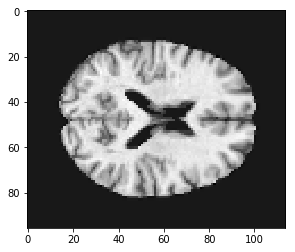

In [124]:
plt.imshow(train_dataset_screening[-1][:,:,48], cmap='gray')
plt.show()

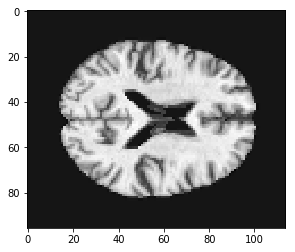

In [126]:
plt.imshow(test_dataset_screening[0][:,:,48], cmap='gray')
plt.show()

In [136]:
!mkdir /analysis/share/ADNI/HDF5_files

In [145]:
train_file_paths

['/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Screening/011_S_0003_9-1-05_Screening_32237_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month12/011_S_0003_9-12-06_Month12_35576_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0003/Month24/011_S_0003_9-12-07_Month24_88252_Dementia_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Screening/022_S_0014_9-29-05_Screening_59375_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Month12/022_S_0014_11-28-06_Month12_59391_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/022_S_0014/Month24/022_S_0014_12-6-07_Month24_87012_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0016/Screening/011_S_0016_9-27-05_Screening_32306_CN_Warped.nii.gz',
 '/analysis/share/ADNI/ADNI_2Yr_15T_quick_preprocessed/011_S_0016/Month12/011_S_0016_10-

In [156]:
train_file_paths = [item.encode('utf-8') for item in train_file_paths]

In [159]:
h5 = h5py.File('/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5', 'w')
h5.create_dataset('X', data=train_dataset)
h5.create_dataset('y', data=train_labels)
h5.create_dataset('files', data=np.array(train_file_paths))
h5.close()

In [160]:
test_file_paths = [item.encode('utf-8') for item in test_file_paths]

In [161]:
h5 = h5py.File('/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5', 'w')
h5.create_dataset('X', data=test_dataset)
h5.create_dataset('y', data=test_labels)
h5.create_dataset('files', data=np.array(test_file_paths))
h5.close()

In [162]:
quit()